In [1]:
# !pip install tensorflow==2.8.0
!pip install efficientnet
!pip install --upgrade wandb
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.15.9
    Uninstalling wandb-0.15.9:
      Successfully uninstalled wandb-0.15.9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 74.1 MB/s eta 0:00:0000:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.17
    Uninstalling botocore-1.31.17:
      Successfully uninstalled botocore-1.31.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.5.4 requires botocore<1.31.18,>=1.31.17, but you have botocore 1.29.165 which is incompatible.


In [2]:
import os
import re
import random
import pandas as pd
import numpy as np
import json
import math
import string
import uuid


### Tensorflow Imports
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,confusion_matrix
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv1D, Add, Activation, Layer, \
                        UpSampling1D, Input, DepthwiseConv2D, Conv2D, \
                        BatchNormalization, ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras.applications import MobileNet


### External models
import efficientnet.tfkeras as efn


### Matplotlib Imports
import matplotlib
import matplotlib.pyplot as plt


### import wandb
import wandb
from wandb.keras import WandbCallback


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [26]:
import boto3
import os
from botocore import UNSIGNED
from botocore.config import Config


def download_files(bucket_name, s3_prefix, local_directory):
    s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
    bucket = s3.Bucket(bucket_name)

    for obj in bucket.objects.filter(Prefix=s3_prefix):
        local_file = os.path.join(local_directory, obj.key)

        if not os.path.exists(os.path.dirname(local_file)):
            os.makedirs(os.path.dirname(local_file))

        bucket.download_file(obj.key, local_file)
        print(f"Downloaded {obj.key} to {local_file}")

download_files('incartdb128x128', 'test', '/content/input')

Downloaded testfiles_class5_fold0_6282.tfrec to /content/input/testfiles_class5_fold0_6282.tfrec
Downloaded testfiles_class5_fold1_6283.tfrec to /content/input/testfiles_class5_fold1_6283.tfrec
Downloaded testfiles_class5_fold2_6282.tfrec to /content/input/testfiles_class5_fold2_6282.tfrec
Downloaded testfiles_class5_fold3_6282.tfrec to /content/input/testfiles_class5_fold3_6282.tfrec
Downloaded testfiles_class5_fold4_6282.tfrec to /content/input/testfiles_class5_fold4_6282.tfrec
Downloaded testfiles_class5_fold5_6282.tfrec to /content/input/testfiles_class5_fold5_6282.tfrec
Downloaded testfiles_class5_fold6_6282.tfrec to /content/input/testfiles_class5_fold6_6282.tfrec
Downloaded testfiles_class5_fold7_6283.tfrec to /content/input/testfiles_class5_fold7_6283.tfrec
Downloaded testfiles_class5_fold8_6282.tfrec to /content/input/testfiles_class5_fold8_6282.tfrec
Downloaded testfiles_class5_fold9_6282.tfrec to /content/input/testfiles_class5_fold9_6282.tfrec


In [25]:
!ls /content/input

In [5]:
hparams = {
    "backbone" : "b0",
    "batch_size" : 32,
    "epochs" : 40,
    "img_size" : 128,
    "lr" : 0.01,
    "optimizer" : "adam",
    "seed": 257,
    "notes": "SACC-s-dropout-changes"
}

In [6]:
class WandBConfigurations():
    def __init__(self, exp_name = "ECG_BEAT_CLASSIFICATION_PAPER_COMMENTS"):
        self.EXPERIMENT_NAME = exp_name
        os.environ["WANDB_API_KEY"] = "221507f411c2ddcc0c17238e115a12c528a482f6"
        wandb.login()

WB = WandBConfigurations()

wandb: Currently logged in as: shreya-srivas02. Use `wandb login --relogin` to force relogin


In [27]:
 class Utils():
    def __init__(self):
        self.seed_everything()

    def id_generator(size=6):
        return str(uuid.uuid4())[:size]

    def setupTPU(self):

        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            print('Running on TPU ', tpu.cluster_spec().as_dict())
        except ValueError:
            tpu = None

        if tpu:
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.TPUStrategy(tpu)
            STRATEGY = strategy
            BATCH_SIZE = 8 * strategy.num_replicas_in_sync
            # wandb.config.hardware = 'TPU'
        else:
            strategy = tf.distribute.get_strategy()
            
        return strategy

    def seed_everything(self):
        np.random.seed(hparams['seed'])
        tf.random.set_seed(hparams['seed'])
        random.seed(a=hparams['seed'])
        os.environ['PYTHONHASHSEED'] = str(hparams['seed'])

UTILS = Utils()
STRATEGY = UTILS.setupTPU()

In [28]:
STRATEGY

In [35]:
class Config():
    def __init__(self):
        self.DO_VAL_SPLIT = True
        self.TRAIN_FILES = sorted(tf.io.gfile.glob('/content/input/test*.tfrec'))[:-1]
        self.TOTAL_TRAIN_IMG = 50258
        self.TOTAL_VAL_IMG = 6282
        self.TOTAL_TEST_IMG = 6282
        self.BACKBONE = hparams['backbone']
        self.IMG_TRAIN_SHAPE = [hparams["img_size"],hparams["img_size"]]
        self.DO_FINETUNE = True
        self.BATCH_SIZE = hparams["batch_size"] # 16
        self.EPOCHES = hparams["epochs"]
        self.SEED = hparams["seed"]
        self.LOSS = tf.keras.losses.CategoricalCrossentropy()
        self.OPTIMIZER = self.get_optimizer()
        self.ACCURACY = []
        self.CALLBACKS = []
        self.STRATEGY = STRATEGY
        self.FOLDS = 9
        self.USE_LR_SCHEDULER = True
        self.FOLD_NUMBER = 0
        self.FOLDS_DICT = {}

        if self.USE_LR_SCHEDULER:
            lrfn = self.get_cosine_schedule_with_warmup(lr=hparams['lr'])
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)
            self.CALLBACKS.append(lr_schedule)

    def get_optimizer(self):
        if hparams['optimizer'] == 'adam':
            return tf.keras.optimizers.Adam(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'rmsprop':
            return tf.keras.optimizers.RMSprop(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'adagrad':
            return tf.keras.optimizers.Adagrad(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'adadelta':
            return tf.keras.optimizers.Adadelta(learning_rate=hparams["lr"])

        return tf.keras.optimizers.Adam(learning_rate=hparams["lr"])

    def get_cosine_schedule_with_warmup(
        self,
        lr = 0.00004,
        num_warmup_steps = 0,
        num_cycles=0.5):
        num_training_steps = self.EPOCHES
        def lrfn(epoch):
            if epoch < num_warmup_steps:
                return (float(epoch) / float(max(5, num_warmup_steps))) * lr
            progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
            return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

        return lrfn


CONFIG = Config()

In [36]:
CONFIG.BATCH_SIZE

32

In [37]:
class Data():
    def __init__(self):
        self.LABELED_TFREC_FORMAT = {
            "image_id": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            'target5': tf.io.FixedLenFeature([], tf.int64),
            'gender' : tf.io.FixedLenFeature([], tf.int64),
            'age_interval' : tf.io.FixedLenFeature([], tf.int64),
        }

    def process_training_data(self, data_file):
        data = tf.io.parse_single_example(data_file, self.LABELED_TFREC_FORMAT)
        img = tf.image.decode_jpeg(data['image'], channels=1)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*CONFIG.IMG_TRAIN_SHAPE, 1])

        age = tf.cast(data['age_interval'], tf.float32) / 10.0
        sex = tf.cast(data['gender'], tf.float32) / 1.0
        tab_data = [tf.cast(tfeat, dtype = tf.float32) for tfeat in [age, sex]]
        tabular_data = tf.stack(tab_data)

        target10 = tf.one_hot(data['target5'], depth=3)

        return {'inp1' : img, 'inp2' : tabular_data}, {"target10" : target10 }

    def process_testing_data(self, data_file):
        data = tf.io.parse_single_example(data_file, self.LABELED_TFREC_FORMAT)
        img = tf.image.decode_jpeg(data['image'], channels=1)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*CONFIG.IMG_TRAIN_SHAPE, 1])

        age = tf.cast(data['age_interval'], tf.float32) / 10.0
        sex = tf.cast(data['gender'], tf.float32) / 1.0
        tab_data = [tf.cast(tfeat, dtype = tf.float32) for tfeat in [age, sex]]
        tabular_data = tf.stack(tab_data)

        target10 = tf.one_hot(data['target5'], depth=3)
        image_id = data["image_id"]

        return {'inp1' : img, 'inp2' : tabular_data}, {"target10" : target10, "image_id":  data['image_id']}

    def val_dataset(self):
        ignore_order = tf.data.Options()
        val_dataset = (
            tf.data.TFRecordDataset(
                CONFIG.FOLDS_DICT["fold_{}".format(CONFIG.FOLD_NUMBER)]["valfiles"],
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_training_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).batch(
                CONFIG.BATCH_SIZE
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )

        return val_dataset

    def train_dataset(self):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        train_dataset = (
            tf.data.TFRecordDataset(
                CONFIG.FOLDS_DICT["fold_{}".format(fold_number)]["trainfiles"],
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_training_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).repeat(
            ).shuffle(
                CONFIG.SEED
            ).batch(
                CONFIG.BATCH_SIZE
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )

        return train_dataset

    def test_dataset(self):
        ignore_order = tf.data.Options()
        TEST_FILES = sorted(tf.io.gfile.glob('/content/input/test*.tfrec'))[-1]
        test_dataset = (
            tf.data.TFRecordDataset(
                TEST_FILES,
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_testing_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).batch(
                CONFIG.BATCH_SIZE *  4
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )
        return test_dataset


In [38]:
class SACCLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(SACCLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='weights_ECG',
                                        shape=(input_shape[0][-1], self.output_dim),
                                        initializer='he_normal',
                                        trainable=True)
        self.kernel_2 = self.add_weight(name='weights_Patient_Metadata',
                                        shape=(input_shape[1][-1], self.output_dim),
                                        initializer='he_normal',
                                        trainable=True)
        self.attention_weights1 = self.add_weight(name='attention_weights_ECG',
                                                 shape=(self.output_dim,),
                                                 initializer='uniform',
                                                 trainable=True)
        self.attention_weights2 = self.add_weight(name='attention_weights_Patient_metadata',
                                                 shape=(self.output_dim,),
                                                 initializer='uniform',
                                                 trainable=True)
        self.dense_layer = tf.keras.layers.Dense(self.output_dim, activation='relu', name='cca_dense')
        super(SACCLayer, self).build(input_shape)

    def call(self, inputs):
        proj_1 = K.dot(inputs[0], self.kernel_1)
        proj_2 = K.dot(inputs[1], self.kernel_2)

        # Apply non-linear transformation
        proj_1 = tf.keras.activations.relu(proj_1)
        proj_2 = tf.keras.activations.relu(proj_2)

        # Attention mechanism
        attention_scores1 = tf.nn.softmax(self.attention_weights1)
        attention_scores2 = tf.nn.softmax(self.attention_weights2)
        proj_1 = attention_scores1 * proj_1
        proj_2 = attention_scores2 * proj_2

        # Non-linear fusion
        fused_representation = tf.keras.layers.concatenate([proj_1, proj_2])
        fused_representation = self.dense_layer(fused_representation)

        return fused_representation

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim)


def depthwise_separable_conv_with_residual_block(x, filters, stride):
    # Depthwise Convolution
    depthwise = DepthwiseConv2D((3, 3), strides=stride, padding='same')(x)
    depthwise = BatchNormalization()(depthwise)
    depthwise = ReLU()(depthwise)

    # Pointwise Convolution
    pointwise = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(depthwise)
    pointwise = BatchNormalization()(pointwise)
    pointwise = ReLU()(pointwise)


    return pointwise


def DualPathwayModel(inp1):
    # Initial Convolution Layers
    conv1 = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inp1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv2D(32, (5, 5), strides=(2, 2), padding='same')(inp1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    

    concatenated = tf.keras.layers.concatenate([conv1, conv2])

    x = depthwise_separable_conv_with_residual_block(concatenated, 64, (1, 1))
    x = depthwise_separable_conv_with_residual_block(x, 128, (2, 2))
    x = tf.keras.layers.Dropout(0.25)(x)
    x = depthwise_separable_conv_with_residual_block(x, 128, (2, 2))
    x = depthwise_separable_conv_with_residual_block(x, 256, (2, 2))
    x = tf.keras.layers.Dropout(0.25)(x)
    x = depthwise_separable_conv_with_residual_block(x, 256, (2, 2))
    x = depthwise_separable_conv_with_residual_block(x, 256, (2, 2)) #<--- Can be removed

    return x

    
def dpm_sacc():
    inp1  = tf.keras.layers.Input(shape = (*CONFIG.IMG_TRAIN_SHAPE, 1), name='inp1')
    inp2  = tf.keras.layers.Input(shape = (2,), name='inp2')
    x1 = DualPathwayModel(inp1)

    x1 = tf.keras.layers.GlobalMaxPooling2D()(x1) # AVG is not good
    x1 = tf.keras.layers.Dropout(0.2)(x1)

    x2 = tf.keras.layers.Dense(8, name='metadata_feature_dense_1', activation='relu')(inp2)
    x2 = tf.keras.layers.concatenate([x2, inp2])

    x = SACCLayer(output_dim=256)([x1, x2])
    
    
    x = tf.keras.layers.Dense(128, name='combine_feature_dense_1', activation='relu')(x)
    x = tf.keras.layers.Dense(64, name='combine_feature_dense_2', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    output10 = tf.keras.layers.Dense(3, activation='softmax', name='target10')(x)

    model = tf.keras.models.Model(inputs = [inp1, inp2], outputs = [output10])

    return model

In [39]:
dpm_sacc().summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 64, 64, 32)   320         ['inp1[0][0]']                   
                                                                                                  
 conv2d_41 (Conv2D)             (None, 64, 64, 32)   832         ['inp1[0][0]']                   
                                                                                                  
 batch_normalization_70 (BatchN  (None, 64, 64, 32)  128         ['conv2d_40[0][0]']        

In [40]:
def fitengine(model, traindataset, valdataset = None, istraining = True):
    model.compile(
        optimizer   =  CONFIG.OPTIMIZER,
        loss        =  CONFIG.LOSS,
        metrics     =  CONFIG.ACCURACY
    )

    history = model.fit(
                traindataset,
                epochs            =   CONFIG.EPOCHES,
                steps_per_epoch   =   CONFIG.TOTAL_TRAIN_IMG//CONFIG.BATCH_SIZE,
                callbacks         =   CONFIG.CALLBACKS,
                validation_data   =   valdataset,
                validation_steps = (CONFIG.TOTAL_VAL_IMG)//(CONFIG.BATCH_SIZE) + 1,
                verbose           =   1
            )

    return history

skf = KFold(n_splits=CONFIG.FOLDS,shuffle=True,random_state=CONFIG.SEED)
for fold_number,(idxT,idxV) in enumerate(skf.split(np.arange(len(CONFIG.TRAIN_FILES)))):
    CONFIG.FOLDS_DICT['fold_{}'.format(fold_number)] = {
                                            "trainfiles" : [CONFIG.TRAIN_FILES[x] for x in idxT],
                                            "valfiles"   : [CONFIG.TRAIN_FILES[x] for x in idxV]
                                            }

fold_number = CONFIG.FOLD_NUMBER
print(CONFIG.FOLDS_DICT['fold_{}'.format(fold_number)]['trainfiles'])
print(CONFIG.FOLDS_DICT['fold_{}'.format(fold_number)]['valfiles'])

run_ = wandb.init(
    project= WB.EXPERIMENT_NAME,
    reinit=True,
    dir = "/root",
    allow_val_change = True,
    config = hparams
)

if CONFIG.STRATEGY is not None:
    with CONFIG.STRATEGY.scope():
        x2 = tf.keras.metrics.Precision(name='precision')
        x3 = tf.keras.metrics.BinaryAccuracy(name='accuracy')
        x4 = tf.keras.metrics.Recall(name='sensitivity')

        CONFIG.ACCURACY.append(x2)
        CONFIG.ACCURACY.append(x3)
        CONFIG.ACCURACY.append(x4)

        model = dpm_sacc()
#         CONFIG.CALLBACKS.append(InLayerLossCallback())
else:
    x2 = tf.keras.metrics.Precision(name='precision')
    x3 = tf.keras.metrics.BinaryAccuracy(name='accuracy')
    x4 = tf.keras.metrics.Recall(name='sensitivity')
    x4 = tf.keras.metrics.Recall(name='sensitivity')

    CONFIG.ACCURACY.append(x2)
    CONFIG.ACCURACY.append(x3)
    CONFIG.ACCURACY.append(x4)

    model = dpm_sacc()

CONFIG.CALLBACKS.append(tf.keras.callbacks.ModelCheckpoint(
                                'model-%s.h5'%(fold_number), monitor='val_loss', verbose=1, save_best_only=True,
                                save_weights_only=True, mode='min', save_freq='epoch'))

CONFIG.CALLBACKS.append(WandbCallback(save_weights_only=True,
                                            log_weights=True,
                                            log_evaluation=True))




DATA = Data()

print("##"*30)

history = fitengine(model, DATA.train_dataset(), valdataset=DATA.val_dataset()) #training model

print('##'*30)

['/content/input/testfiles_class5_fold0_6282.tfrec', '/content/input/testfiles_class5_fold1_6283.tfrec', '/content/input/testfiles_class5_fold2_6282.tfrec', '/content/input/testfiles_class5_fold4_6282.tfrec', '/content/input/testfiles_class5_fold5_6282.tfrec', '/content/input/testfiles_class5_fold6_6282.tfrec', '/content/input/testfiles_class5_fold7_6283.tfrec', '/content/input/testfiles_class5_fold8_6282.tfrec']
['/content/input/testfiles_class5_fold3_6282.tfrec']


accuracy,▁
epoch,▁
loss,▁
lr,▁
precision,▁
sensitivity,▁
val_accuracy,▁
val_loss,▁
val_precision,▁
val_sensitivity,▁
accuracy,0.71352


############################################################


wandb: WARNING WandbCallback is unable to log validation data. When using a generator for validation_data, you must pass validation_steps


Epoch 1/40


2023-10-28 17:21:18.754081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1569/1570 [============================>.] - ETA: 0s - loss: 0.1743 - precision: 0.9577 - accuracy: 0.9681 - sensitivity: 0.9460
Epoch 1: val_loss improved from inf to 2.61897, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231028_172013-9vnf4cg5/files/model-best)... Done. 0.0s


1570/1570 [==============================] - 86s 48ms/step - loss: 0.1743 - precision: 0.9577 - accuracy: 0.9681 - sensitivity: 0.9460 - val_loss: 2.6190 - val_precision: 0.3356 - val_accuracy: 0.5587 - val_sensitivity: 0.3305 - lr: 0.0100
Epoch 2/40
1570/1570 [==============================] - ETA: 0s - loss: 0.0988 - precision: 0.9771 - accuracy: 0.9836 - sensitivity: 0.9737
Epoch 2: val_loss improved from 2.61897 to 0.07203, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231028_172013-9vnf4cg5/files/model-best)... Done. 0.0s


1570/1570 [==============================] - 74s 47ms/step - loss: 0.0988 - precision: 0.9771 - accuracy: 0.9836 - sensitivity: 0.9737 - val_loss: 0.0720 - val_precision: 0.9802 - val_accuracy: 0.9862 - val_sensitivity: 0.9784 - lr: 0.0100
Epoch 3/40
1570/1570 [==============================] - ETA: 0s - loss: 0.0825 - precision: 0.9795 - accuracy: 0.9857 - sensitivity: 0.9777
Epoch 3: val_loss did not improve from 0.07203
1570/1570 [==============================] - 66s 42ms/step - loss: 0.0825 - precision: 0.9795 - accuracy: 0.9857 - sensitivity: 0.9777 - val_loss: 0.0767 - val_precision: 0.9831 - val_accuracy: 0.9884 - val_sensitivity: 0.9820 - lr: 0.0099
Epoch 4/40
1569/1570 [============================>.] - ETA: 0s - loss: 0.0744 - precision: 0.9819 - accuracy: 0.9874 - sensitivity: 0.9801
Epoch 4: val_loss improved from 0.07203 to 0.04853, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231028_172013-9vnf4cg5/files/model-best)... Done. 0.0s


1570/1570 [==============================] - 74s 47ms/step - loss: 0.0744 - precision: 0.9820 - accuracy: 0.9874 - sensitivity: 0.9801 - val_loss: 0.0485 - val_precision: 0.9873 - val_accuracy: 0.9913 - val_sensitivity: 0.9866 - lr: 0.0099
Epoch 5/40
1569/1570 [============================>.] - ETA: 0s - loss: 0.0602 - precision: 0.9841 - accuracy: 0.9890 - sensitivity: 0.9830
Epoch 5: val_loss did not improve from 0.04853
1570/1570 [==============================] - 66s 42ms/step - loss: 0.0602 - precision: 0.9841 - accuracy: 0.9890 - sensitivity: 0.9830 - val_loss: 0.1156 - val_precision: 0.9619 - val_accuracy: 0.9691 - val_sensitivity: 0.9446 - lr: 0.0098
Epoch 6/40
1569/1570 [============================>.] - ETA: 0s - loss: 0.0572 - precision: 0.9859 - accuracy: 0.9901 - sensitivity: 0.9844
Epoch 6: val_loss did not improve from 0.04853
1570/1570 [==============================] - 67s 42ms/step - loss: 0.0572 - precision: 0.9859 - accuracy: 0.9901 - sensitivity: 0.9844 - val_loss:

wandb: Adding directory to artifact (/root/wandb/run-20231028_172013-9vnf4cg5/files/model-best)... Done. 0.0s


1570/1570 [==============================] - 74s 47ms/step - loss: 0.0469 - precision: 0.9876 - accuracy: 0.9916 - sensitivity: 0.9871 - val_loss: 0.0387 - val_precision: 0.9896 - val_accuracy: 0.9928 - val_sensitivity: 0.9889 - lr: 0.0090
Epoch 10/40
1570/1570 [==============================] - ETA: 0s - loss: 0.0424 - precision: 0.9894 - accuracy: 0.9927 - sensitivity: 0.9888
Epoch 10: val_loss did not improve from 0.03871
1570/1570 [==============================] - 66s 42ms/step - loss: 0.0424 - precision: 0.9894 - accuracy: 0.9927 - sensitivity: 0.9888 - val_loss: 0.0436 - val_precision: 0.9900 - val_accuracy: 0.9932 - val_sensitivity: 0.9895 - lr: 0.0088
Epoch 11/40
1570/1570 [==============================] - ETA: 0s - loss: 0.0412 - precision: 0.9894 - accuracy: 0.9927 - sensitivity: 0.9889
Epoch 11: val_loss did not improve from 0.03871
1570/1570 [==============================] - 66s 42ms/step - loss: 0.0412 - precision: 0.9894 - accuracy: 0.9927 - sensitivity: 0.9889 - val_l

wandb: Adding directory to artifact (/root/wandb/run-20231028_172013-9vnf4cg5/files/model-best)... Done. 0.0s


1570/1570 [==============================] - 74s 47ms/step - loss: 0.0262 - precision: 0.9935 - accuracy: 0.9956 - sensitivity: 0.9933 - val_loss: 0.0330 - val_precision: 0.9930 - val_accuracy: 0.9953 - val_sensitivity: 0.9930 - lr: 0.0058
Epoch 20/40
1569/1570 [============================>.] - ETA: 0s - loss: 0.0245 - precision: 0.9941 - accuracy: 0.9960 - sensitivity: 0.9939
Epoch 20: val_loss improved from 0.03301 to 0.02791, saving model to model-0.h5


wandb: Adding directory to artifact (/root/wandb/run-20231028_172013-9vnf4cg5/files/model-best)... Done. 0.0s


1570/1570 [==============================] - 74s 47ms/step - loss: 0.0245 - precision: 0.9941 - accuracy: 0.9960 - sensitivity: 0.9939 - val_loss: 0.0279 - val_precision: 0.9932 - val_accuracy: 0.9954 - val_sensitivity: 0.9930 - lr: 0.0054
Epoch 21/40
1570/1570 [==============================] - ETA: 0s - loss: 0.0243 - precision: 0.9936 - accuracy: 0.9957 - sensitivity: 0.9936
Epoch 21: val_loss did not improve from 0.02791
1570/1570 [==============================] - 66s 42ms/step - loss: 0.0243 - precision: 0.9936 - accuracy: 0.9957 - sensitivity: 0.9936 - val_loss: 0.0369 - val_precision: 0.9925 - val_accuracy: 0.9950 - val_sensitivity: 0.9925 - lr: 0.0050
Epoch 22/40
1569/1570 [============================>.] - ETA: 0s - loss: 0.0222 - precision: 0.9945 - accuracy: 0.9963 - sensitivity: 0.9944
Epoch 22: val_loss did not improve from 0.02791
1570/1570 [==============================] - 66s 42ms/step - loss: 0.0222 - precision: 0.9945 - accuracy: 0.9963 - sensitivity: 0.9944 - val_l

In [41]:
model.save('model_last_epoch.h5')
model_till_last_epoch = model
SAVED_MODEL_LOC = "model-0.h5"
model = dpm_sacc()
model.load_weights(SAVED_MODEL_LOC)

50/50 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

      Normal     0.9939    0.9963    0.9951      4086
         SEB     0.9620    0.8939    0.9267       198
         VEB     0.9955    0.9975    0.9965      1998

    accuracy                         0.9935      6282
   macro avg     0.9838    0.9626    0.9728      6282
weighted avg     0.9934    0.9935    0.9934      6282

50/50 [==============================] - 1s 18ms/step


wandb: Adding directory to artifact (/kaggle/working)... Done. 0.0s


              precision    recall  f1-score   support

      Normal     0.9966    0.9976    0.9971      4086
         SEB     0.9691    0.9495    0.9592       198
         VEB     0.9975    0.9975    0.9975      1998

    accuracy                         0.9960      6282
   macro avg     0.9877    0.9815    0.9846      6282
weighted avg     0.9960    0.9960    0.9960      6282



<Artifact Full_Logs>

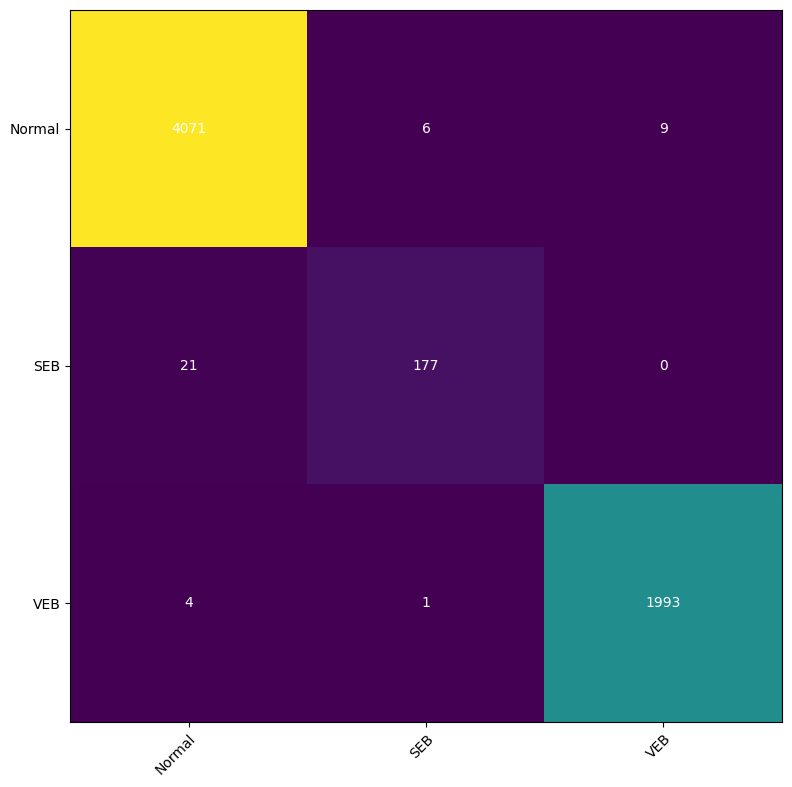

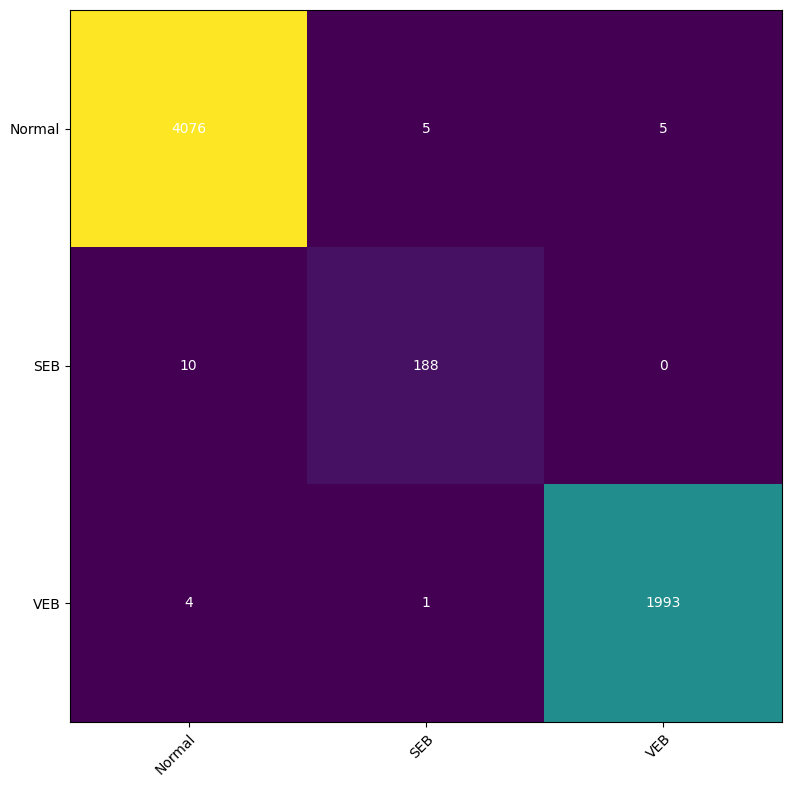

In [43]:
NAME = ['Normal', "SEB",  'VEB']
for model_type, trained_model in zip(['best_epoch', 'last_epoch'], [model, model_till_last_epoch]):
    test_imgs = DATA.test_dataset().map(lambda data, ids: data)
    img_labels_ds = DATA.test_dataset().map(lambda data, ids: ids).unbatch()

    STEPS = (CONFIG.TOTAL_TEST_IMG)//(CONFIG.BATCH_SIZE*4) + 1

    y_pred = trained_model.predict(test_imgs,steps = int(STEPS), verbose=1)
    test_labels = next(iter(img_labels_ds.batch(int(CONFIG.TOTAL_TEST_IMG) + 1)))
    y_true = test_labels["target10"].numpy()
    pd.DataFrame({
            'image_id'  : test_labels["image_id"].numpy(),
            'actual'  : np.argmax(y_true, axis=1),
            'predicted'      : np.argmax(y_pred, axis=1)
            }).to_csv('prediction_{}.csv'.format(model_type), index=False)

    df = pd.read_csv("prediction_{}.csv".format(model_type))

    run_.log({f"{model_type}_pr": wandb.plot.pr_curve(np.argmax(y_true, axis=1), y_pred, labels=NAME)})
    run_.log({f"{model_type}_roc": wandb.plot.roc_curve(np.argmax(y_true, axis=1), y_pred, labels=NAME)})

    cm = wandb.plot.confusion_matrix(
                    y_true=np.argmax(y_true, axis=1),
                    preds=np.argmax(y_pred, axis=1),
                    class_names=NAME)

    run_.log({f"{model_type}_conf_mat": cm})

    harvest = confusion_matrix(df['actual'], df['predicted'])
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(harvest)
    ax.set_xticks(np.arange(len(NAME)))
    ax.set_yticks(np.arange(len(NAME)))
    ax.set_xticklabels(NAME)
    ax.set_yticklabels(NAME)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    for i in range(len(NAME)):
        for j in range(len(NAME)):
            text = ax.text(j, i, harvest[i, j],
                        ha="center", va="center", color="w")

    fig.tight_layout()
    run_.log({f"{model_type}_cm": plt})

    from sklearn.metrics import classification_report
    target_names = NAME
    x_ = classification_report(df['actual'], df['predicted'], target_names=target_names, digits=4)
    x2 = classification_report(df['actual'], df['predicted'], target_names=target_names, digits=4, output_dict=True)
    print(x_)
    run_.log({f"{model_type}_CR": x2})


## log more
artifact = wandb.Artifact("Full_Logs", type="logs")
artifact.add_dir("/kaggle/working/")
wandb.log_artifact(artifact)

In [44]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph


def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

model = dpm_sacc()

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )




=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [45]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_64 (Conv2D)             (None, 64, 64, 32)   320         ['inp1[0][0]']                   
                                                                                                  
 conv2d_65 (Conv2D)             (None, 64, 64, 32)   832         ['inp1[0][0]']                   
                                                                                                  
 batch_normalization_112 (Batch  (None, 64, 64, 32)  128         ['conv2d_64[0][0]']        

In [46]:
tf.keras.utils.plot_model(
    dpm_sacc(),
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

run_.finish()

accuracy,▁▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
precision,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
sensitivity,▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
val_accuracy,▁█████▇█████████████████████████████████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁█████▇█████████████████████████████████
val_sensitivity,▁███▇█▇█████████████████████████████████
accuracy,0.99834
